### Testing on F0 curves

In [12]:
from src.data.components.feature_extractors import LibriTTSFeatureExtractor
from src.utils.freq_transforms import (
    fourier_transform_truncate_reconstruct,
    wavelet_transform_truncate_reconstruct,
)
from sklearn.metrics import mean_squared_error
from src.utils.plots import plot_signals_with_mse_pearson
from src.utils.approximation import fit_sine_to_signal
from src.utils.old_features import F0Extractor, get_features_from_lab_root

from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import numpy as np
import os

from decouple import config, Config, RepositoryEnv

config = Config(RepositoryEnv("../.env"))

In [13]:
config("DATA_CACHE")

'/Users/lukas/Desktop/projects/MIT/data/cache'

In [14]:
LAB_ROOT = "/Users/lukas/Desktop/projects/MIT/data/LibriTTSCorpusLabel/debug"
WAV_ROOT = "/Users/lukas/Desktop/projects/MIT/data/LibriTTS/debug"
CACHE_PATH = "/Users/lukas/Desktop/projects/MIT/data/cache"

In [15]:
f0_extractor = F0Extractor(modes=["min", "max", "mean", "curve"])

In [16]:
# samples = get_features_from_lab_root(
#     lab_root=LAB_ROOT, wav_root=WAV_ROOT, feature_extractor=f0_extractor
# )

In [17]:
extractor = LibriTTSFeatureExtractor(
    lab_root=LAB_ROOT, wav_root=WAV_ROOT, data_cache=CACHE_PATH
)

Searching for features from /Users/lukas/Desktop/projects/MIT/data/LibriTTSCorpusLabel/debug...
Loaded 13 samples from cache.
Finished extracting 13 samples.


In [18]:
from src.data.components.feature_extractors import LibriTTSFeatureExtractor

extractor = LibriTTSFeatureExtractor(
    lab_root=LAB_ROOT, wav_root=WAV_ROOT, data_cache=CACHE_PATH
)

Searching for features from /Users/lukas/Desktop/projects/MIT/data/LibriTTSCorpusLabel/debug...
Loaded 13 samples from cache.
Finished extracting 13 samples.


In [19]:
len(extractor.samples)

13

In [20]:
all_texts = extractor.get_all_texts()
words = [word for txt in all_texts for word in txt.split(" ")]
len(all_texts), len(words)

(13, 91)

In [21]:
all_curves = extractor.get_all_f0_curve()
all_word_curves = [word_curve for ut in all_curves for word_curve in ut]
len(all_curves), len(all_word_curves)

(13, 91)

In [22]:
n = 4

mse_ft = []
pearson_ft = []
mse_wv = []
pearson_wv = []
mse_sine = []
pearson_sine = []

sine_coeffs = []
ft_coeffs = []
# wv_coeffs = []

for curve in all_word_curves:
    if curve.shape[0] == 0 or len(curve) < n:
        continue

    # reconstructed, params = fit_sine_to_signal(curve)
    # if reconstructed is None:
    #     continue
    # mse_sine.append(mean_squared_error(curve, reconstructed))
    # pearson_sine.append(pearsonr(curve, reconstructed)[0])
    # sine_coeffs.append(params)

    truncated_coeffs, reconstructed = fourier_transform_truncate_reconstruct(curve, n)
    mse_ft.append(mean_squared_error(curve, reconstructed))
    pearson_ft.append(pearsonr(curve, reconstructed)[0])
    ft_coeffs.append(truncated_coeffs)

    # truncated_coeffs, reconstructed = wavelet_transform_truncate_reconstruct(curve, n)
    # mse_wv.append(mean_squared_error(curve, reconstructed))
    # pearson_wv.append(pearsonr(curve, reconstructed)[0])

print(f"mean mse ft: {np.mean(mse_ft)}")
print(f"mean pearson ft: {np.mean(pearson_ft)}")
# print(f"mean mse wv: {np.mean(mse_wv)}")
# print(f"mean pearson wv: {np.mean(pearson_wv)}")
# print(f"mean mse sine: {np.mean(mse_sine)}")
# print(f"mean pearson sine: {np.mean(pearson_sine)}")

mean mse ft: 0.14402512491571745
mean pearson ft: 0.9111567856706793


In [23]:
ft_coeffs = np.array([np.real(c)[:4] for c in ft_coeffs])

In [24]:
# randomly sample 1000 curves
import random

random.seed(42)
random_coeffs = random.sample(ft_coeffs, 10000)

TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

In [ ]:
# do PCA on the coefficients

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(random_coeffs)
pca.components_

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10000,) + inhomogeneous part.

In [ ]:
# tsne with sine coeffs

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0)

X = np.array(random_coeffs)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(6, 5))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c="red")
plt.show()

/var/folders/hg/k29n8l193w76mcsdz5qf1w5h0000gn/T/ipykernel_71940/2420244217.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(random_coeffs)


ValueError: setting an array element with a sequence.

/opt/homebrew/Caskroom/miniforge/base/envs/prosody/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


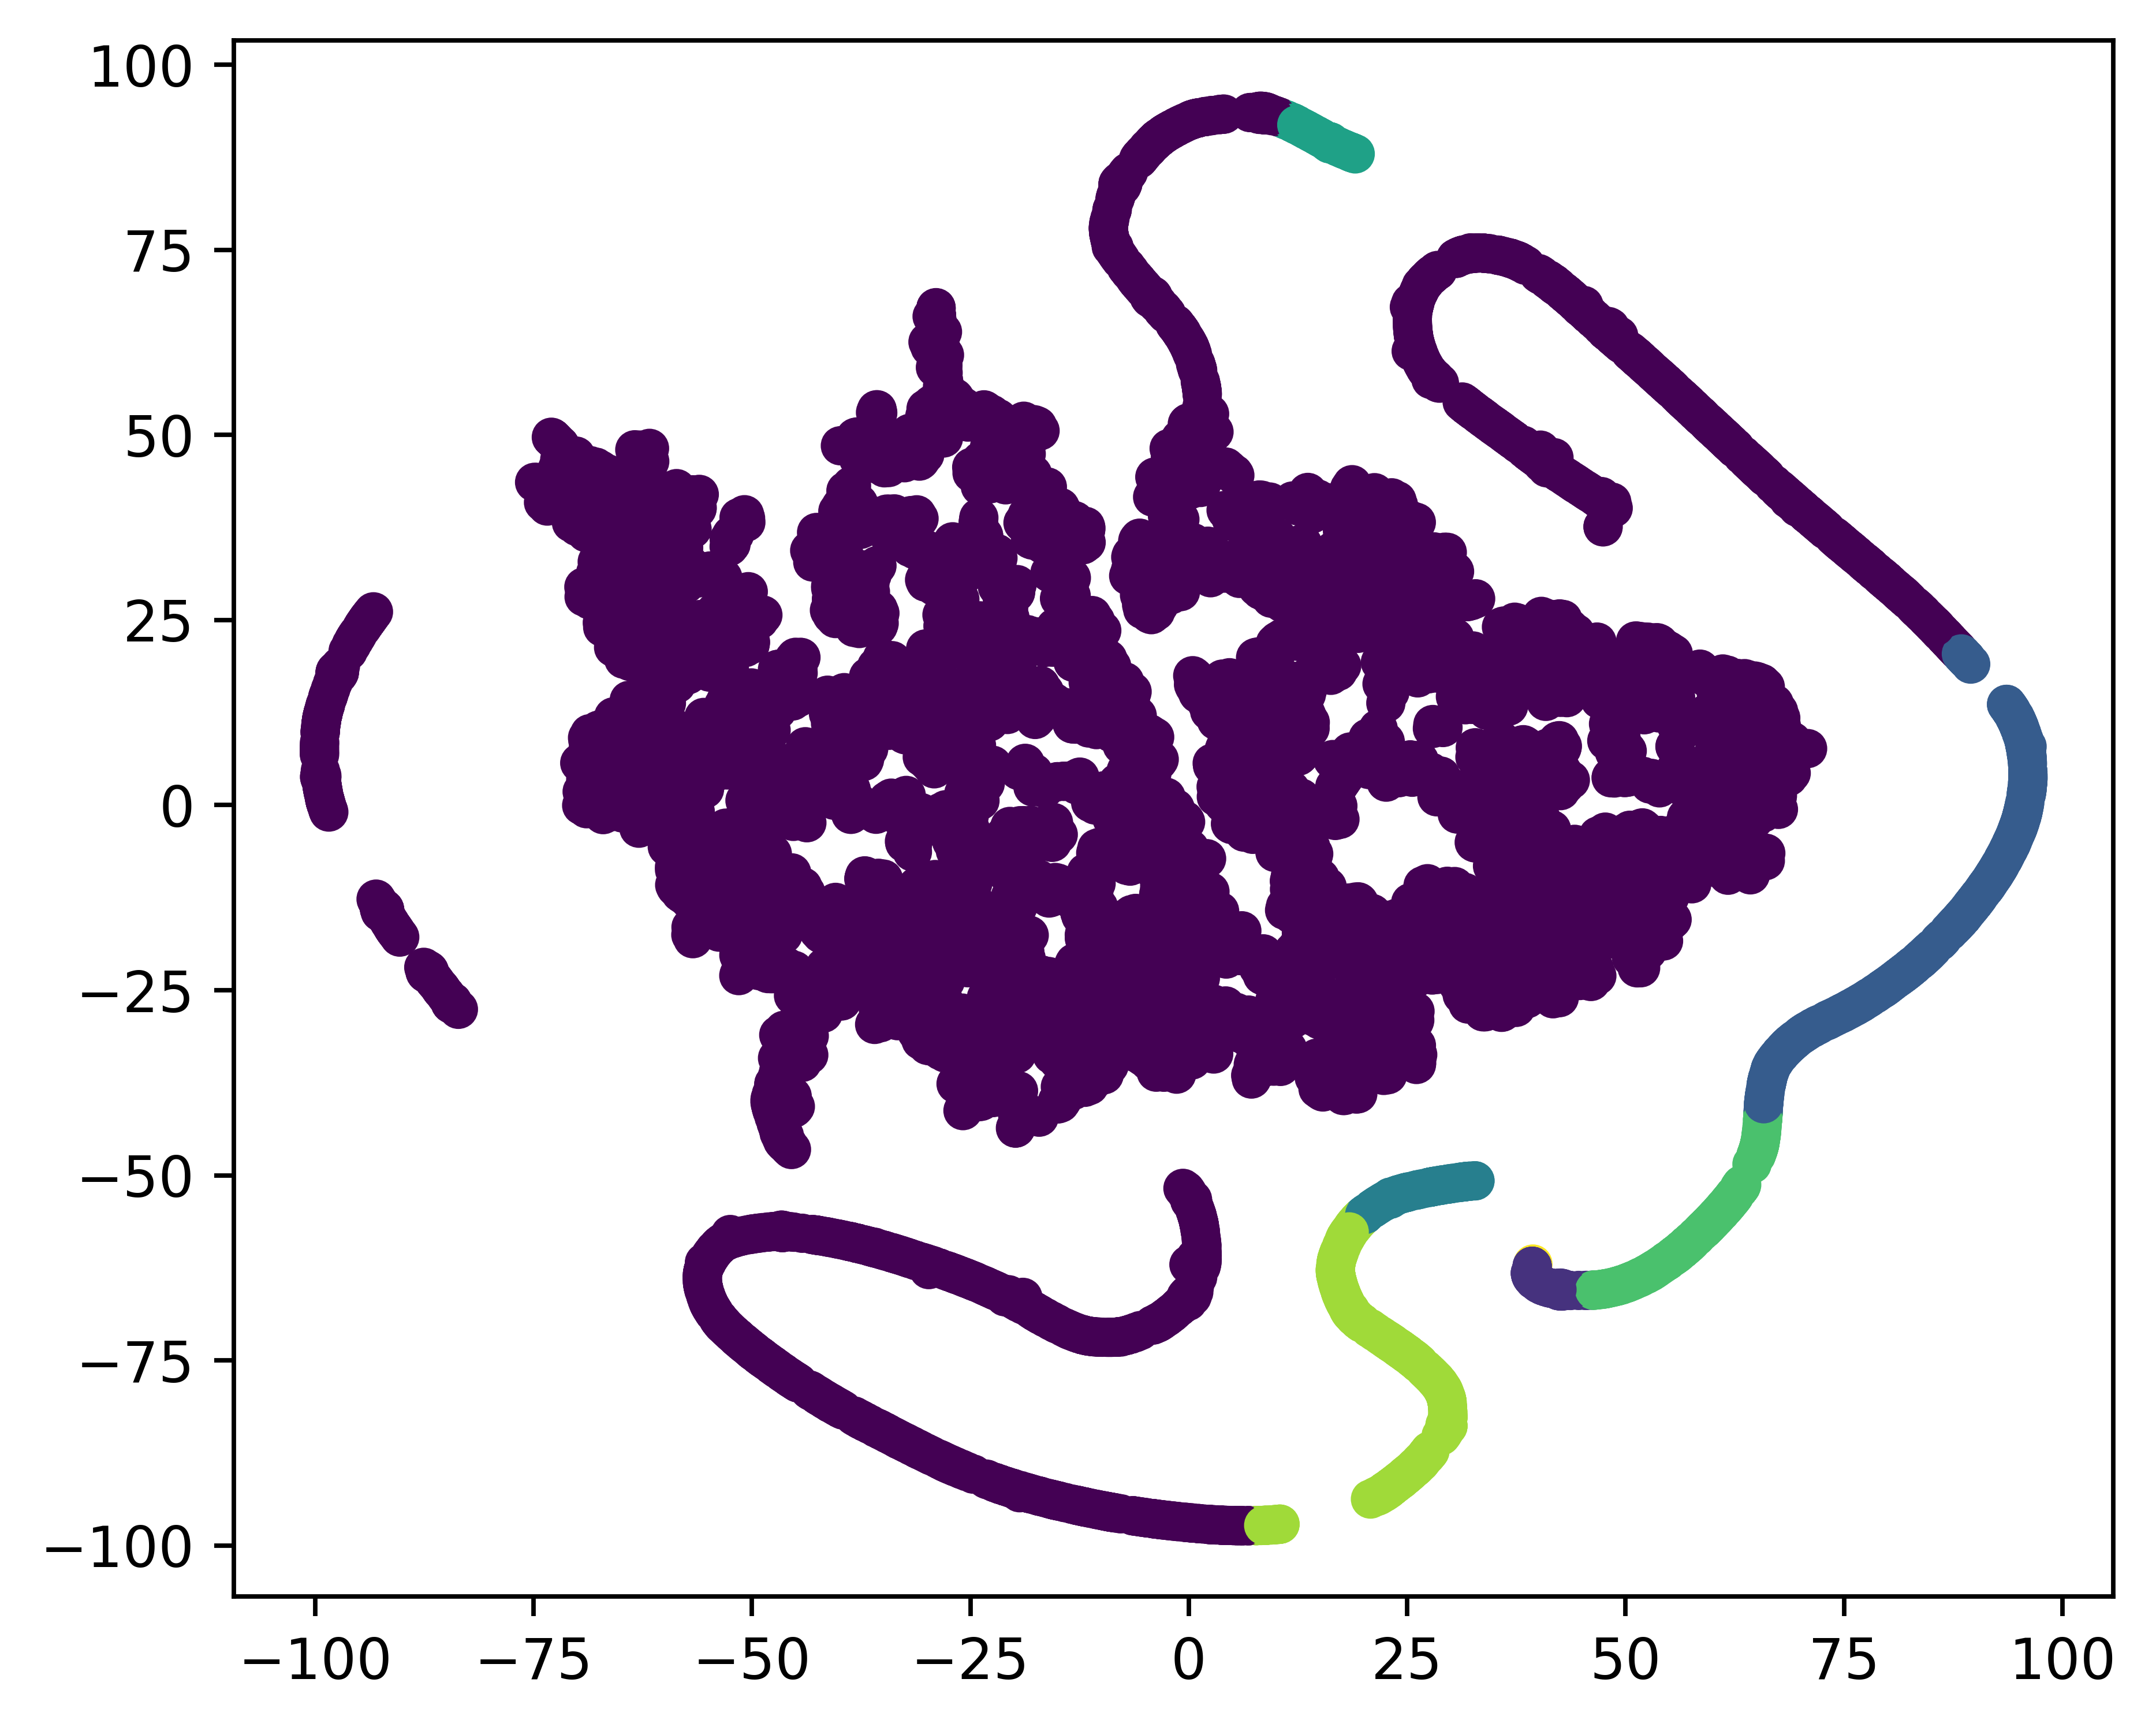

In [ ]:
# perform kmeans on random coeffs and then plot tsned coeffs with kmeans labels

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8, random_state=0).fit(X)
kmeans.labels_

plt.figure(figsize=(6, 5))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=kmeans.labels_)
plt.show()

385


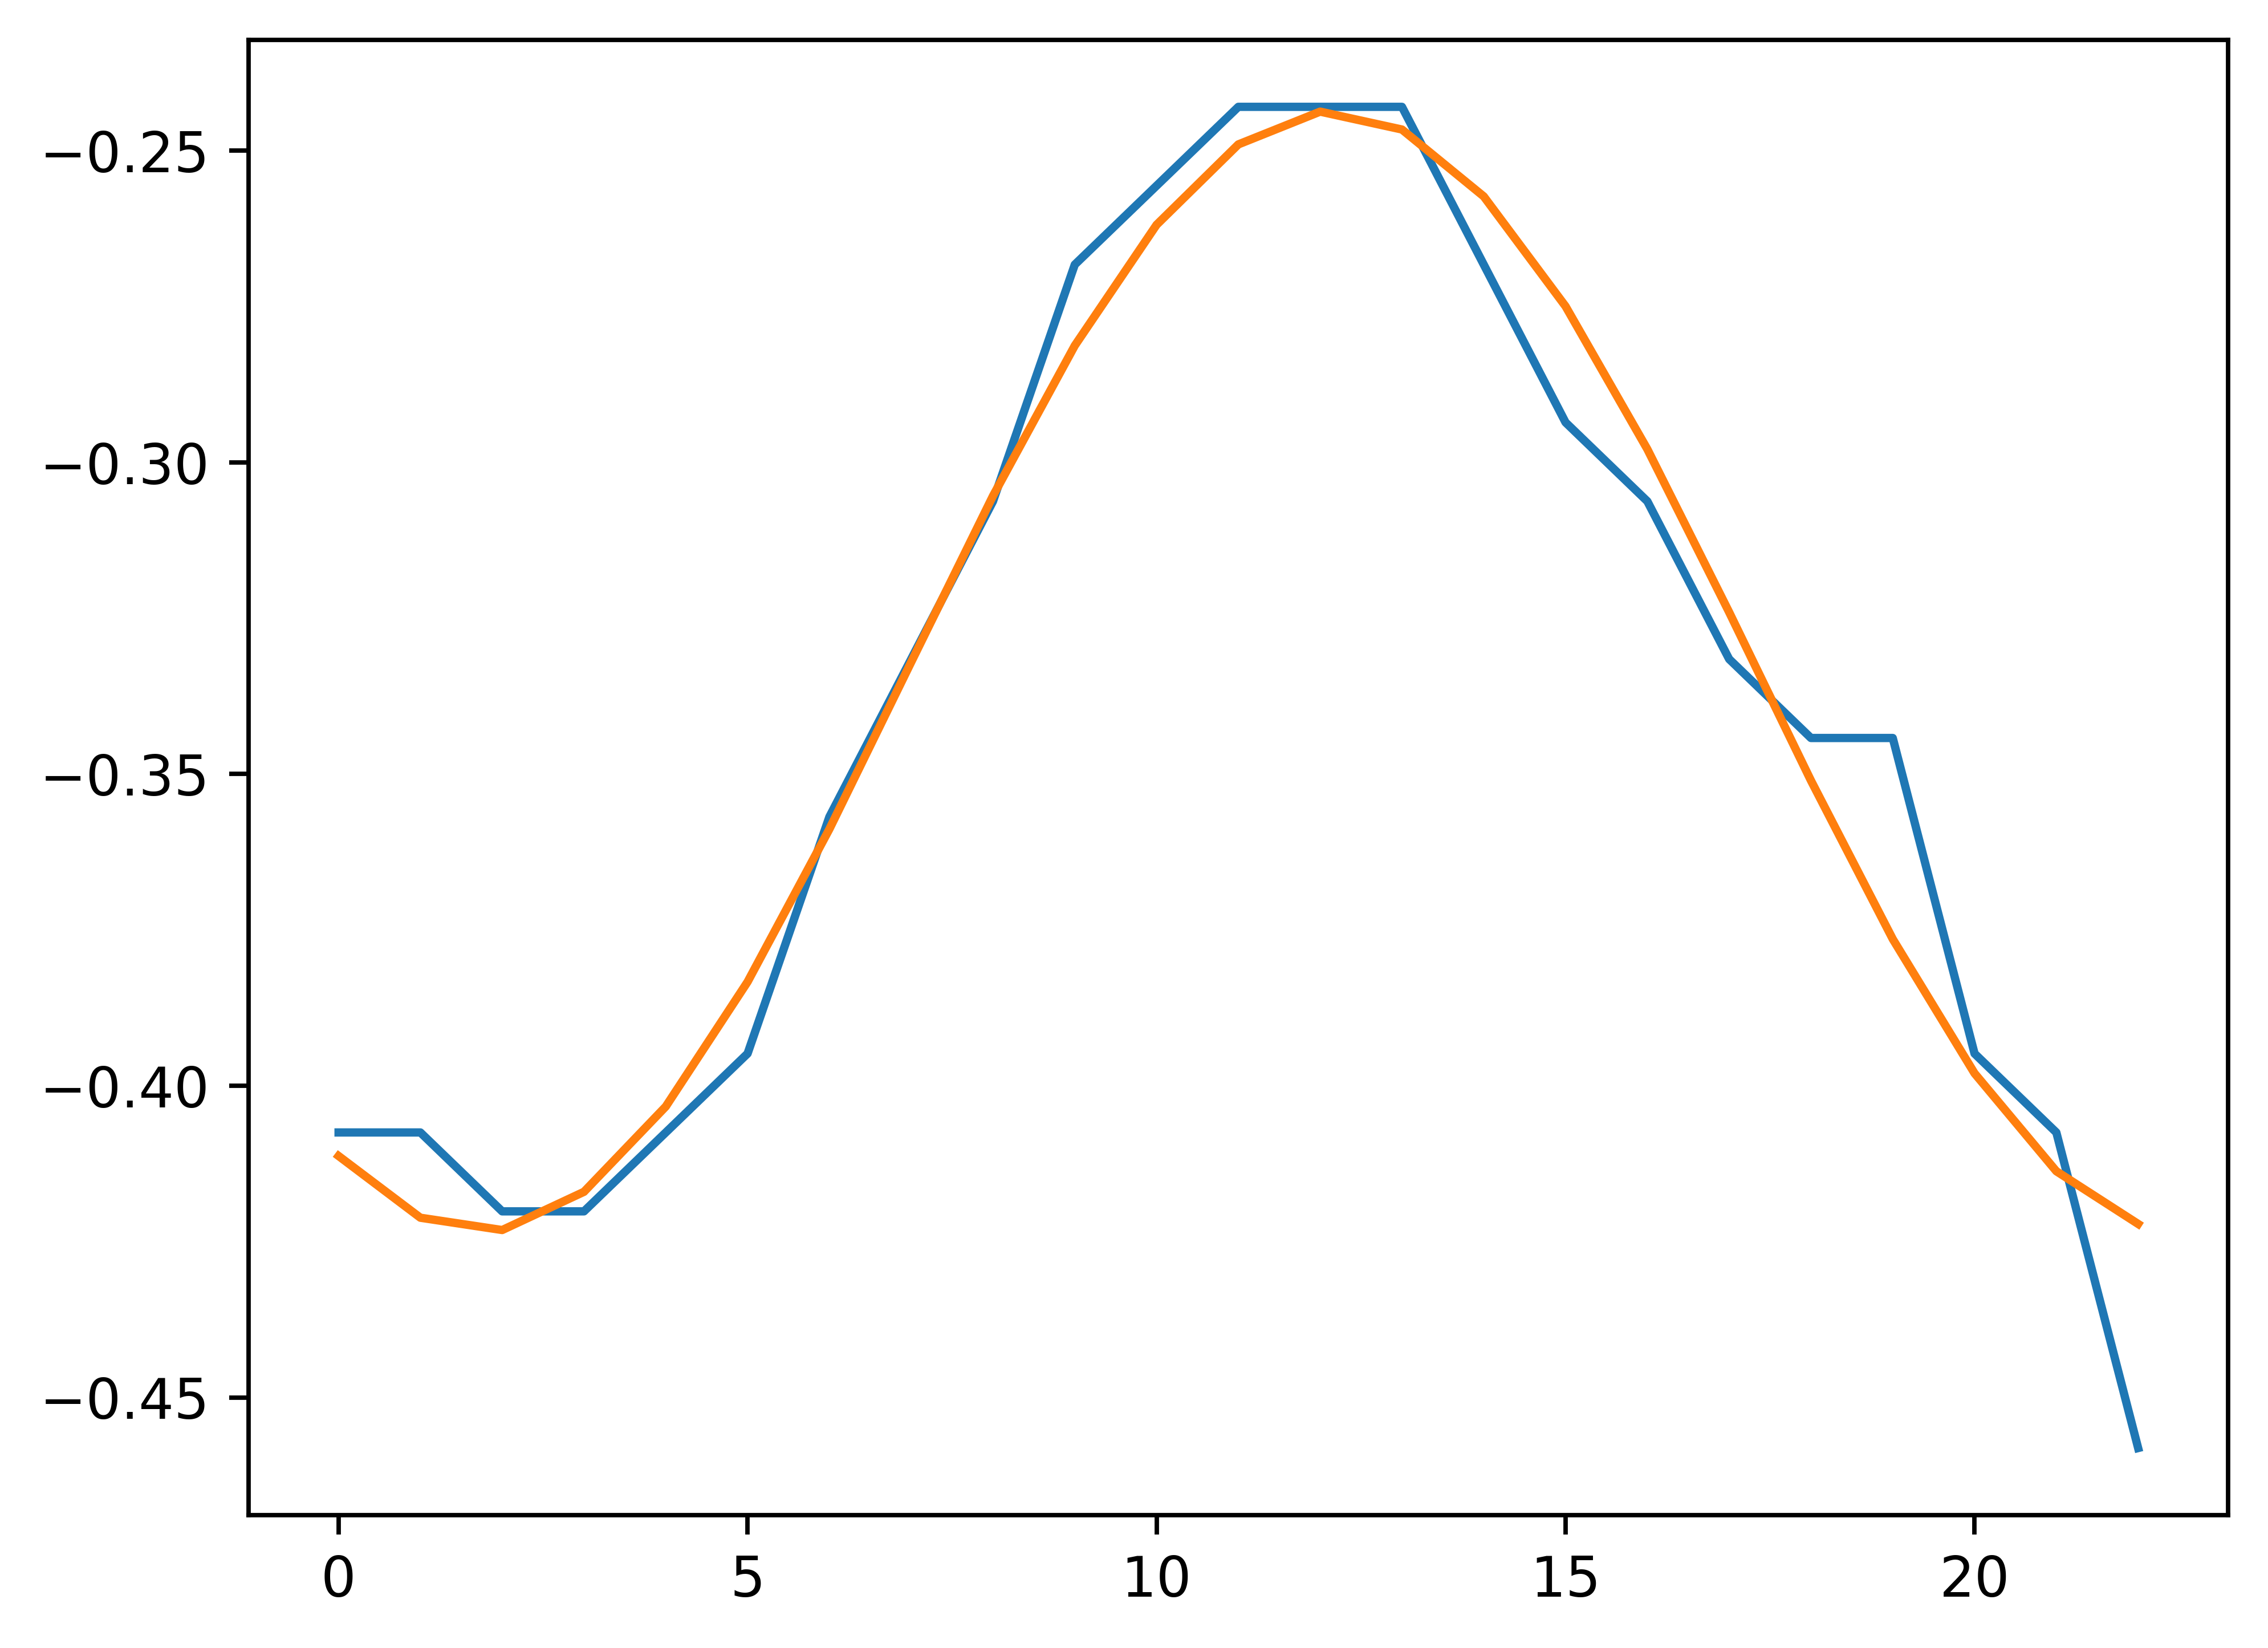

In [ ]:
# plot a sine curve from cluster 0

cluster_0 = [
    curve for curve, label in zip(all_word_curves, kmeans.labels_) if label == 2
]
print(len(cluster_0))
cluster_0 = cluster_0[26]

reconstructed, params = fit_sine_to_signal(cluster_0)
plt.plot(cluster_0)
plt.plot(reconstructed)

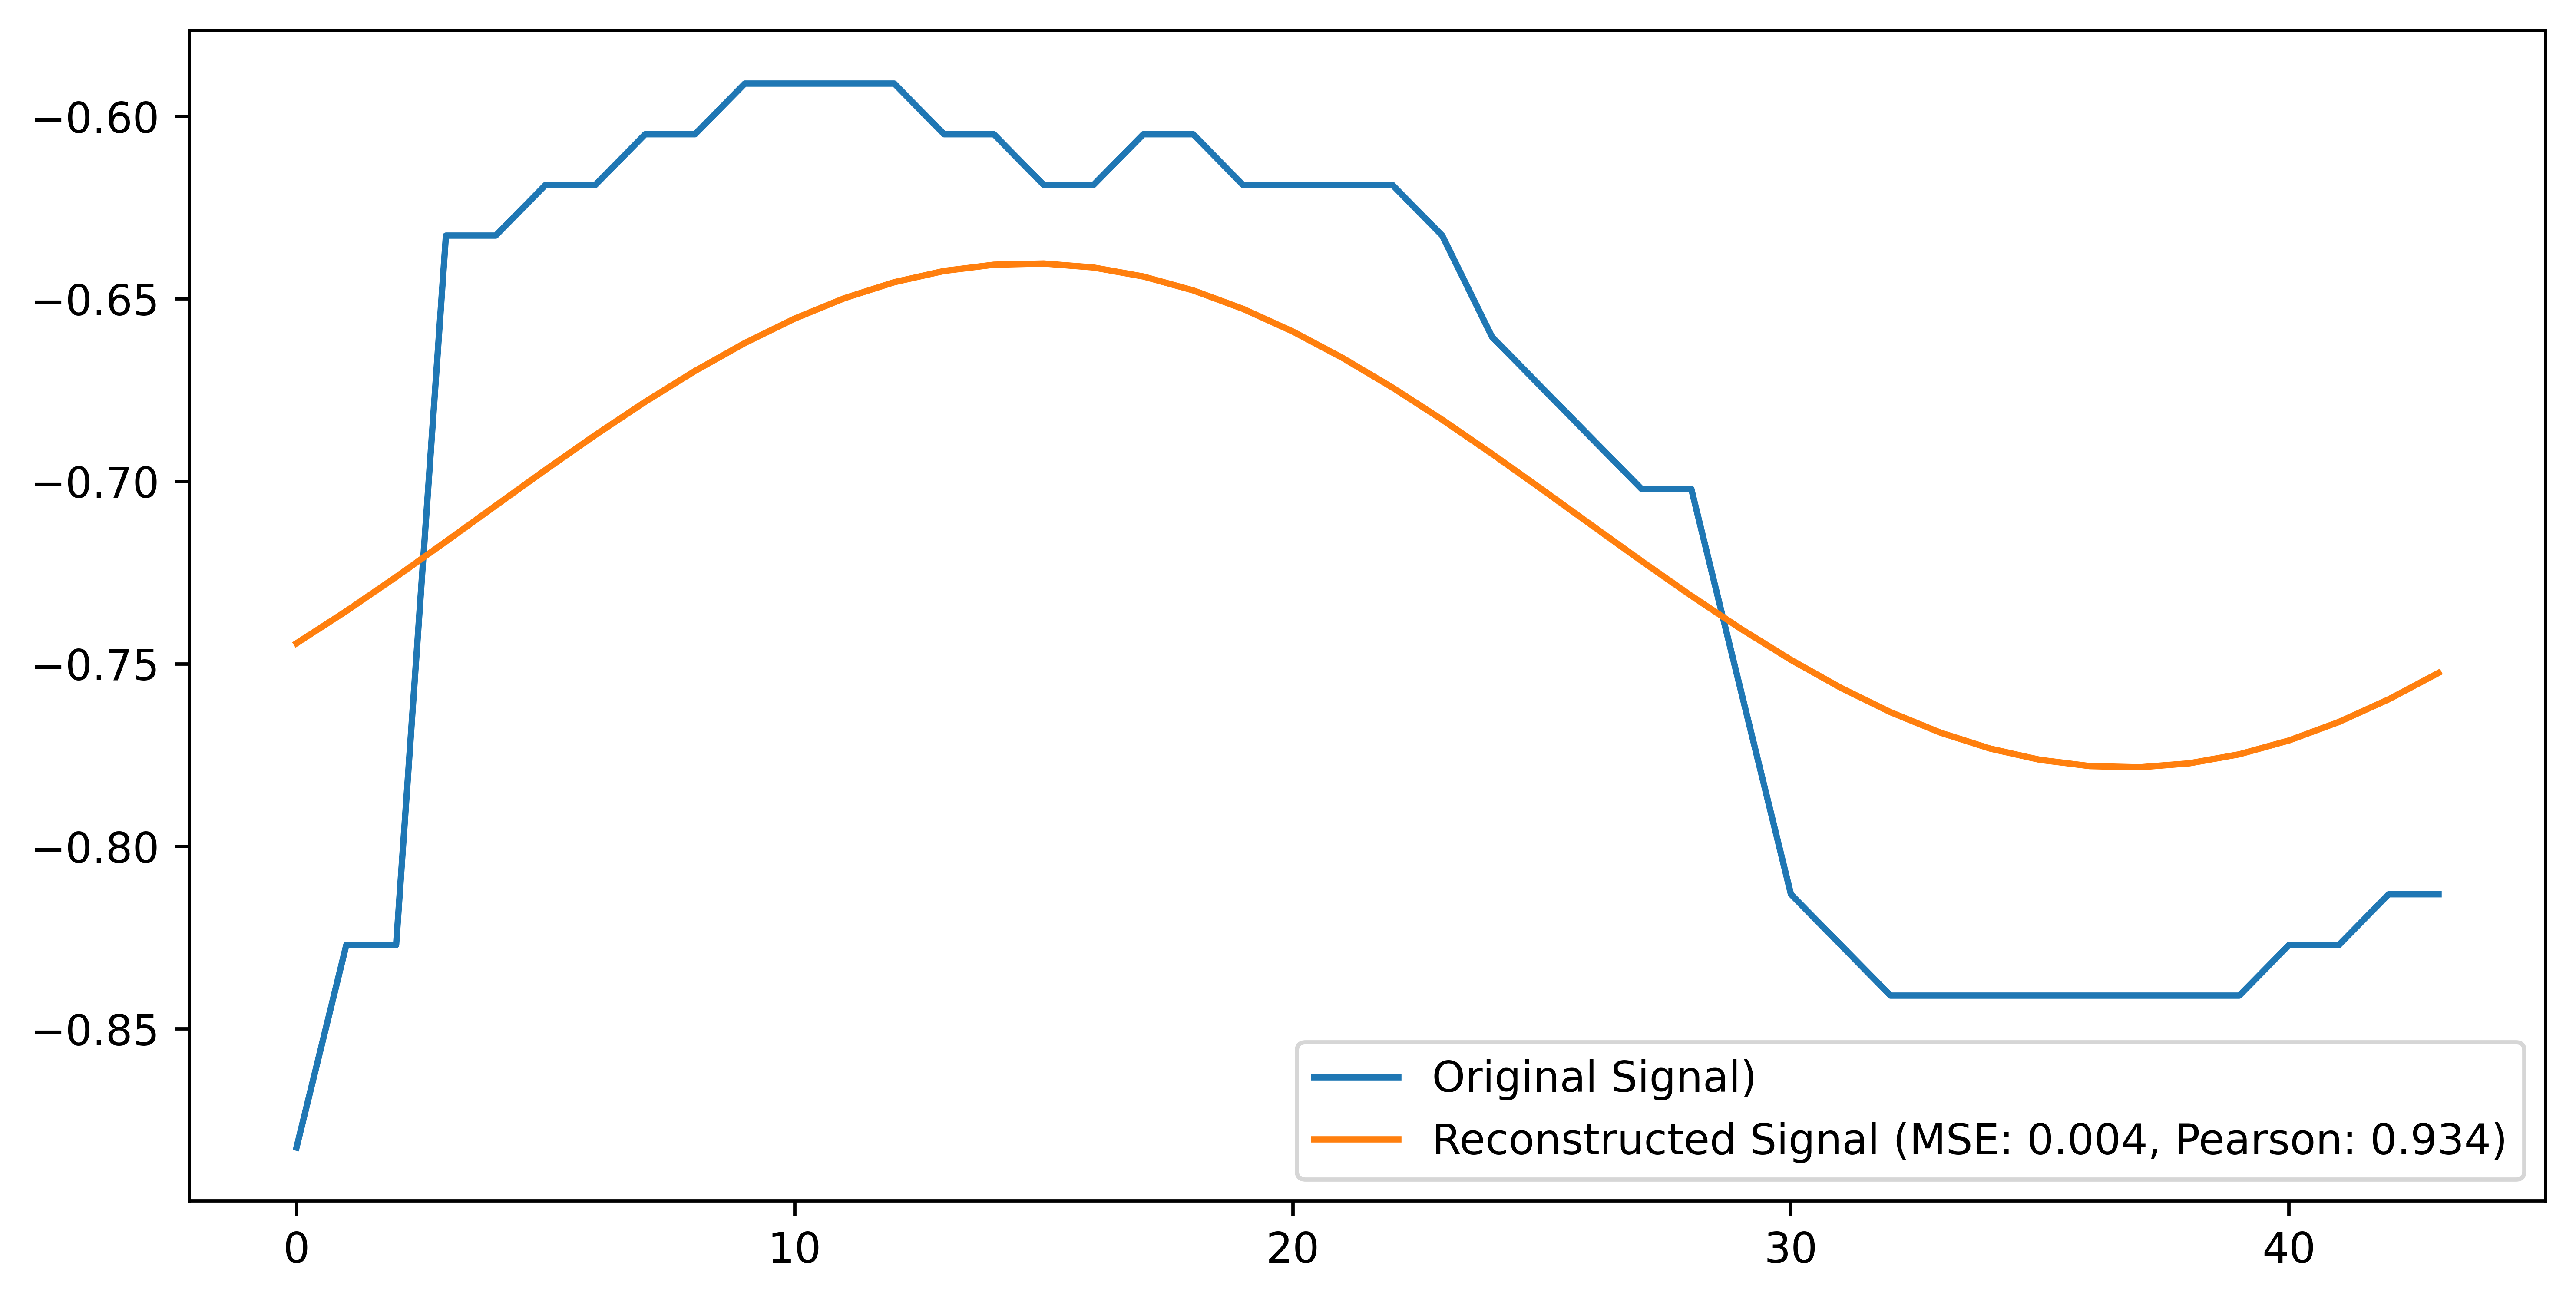

In [37]:
idx = 25

n = 32

coeff, rec = fourier_transform_truncate_reconstruct(
    all_word_curves[idx], min(n, len(all_word_curves[idx])), regularize=True
)
plot_signals_with_mse_pearson(all_word_curves[idx], rec)

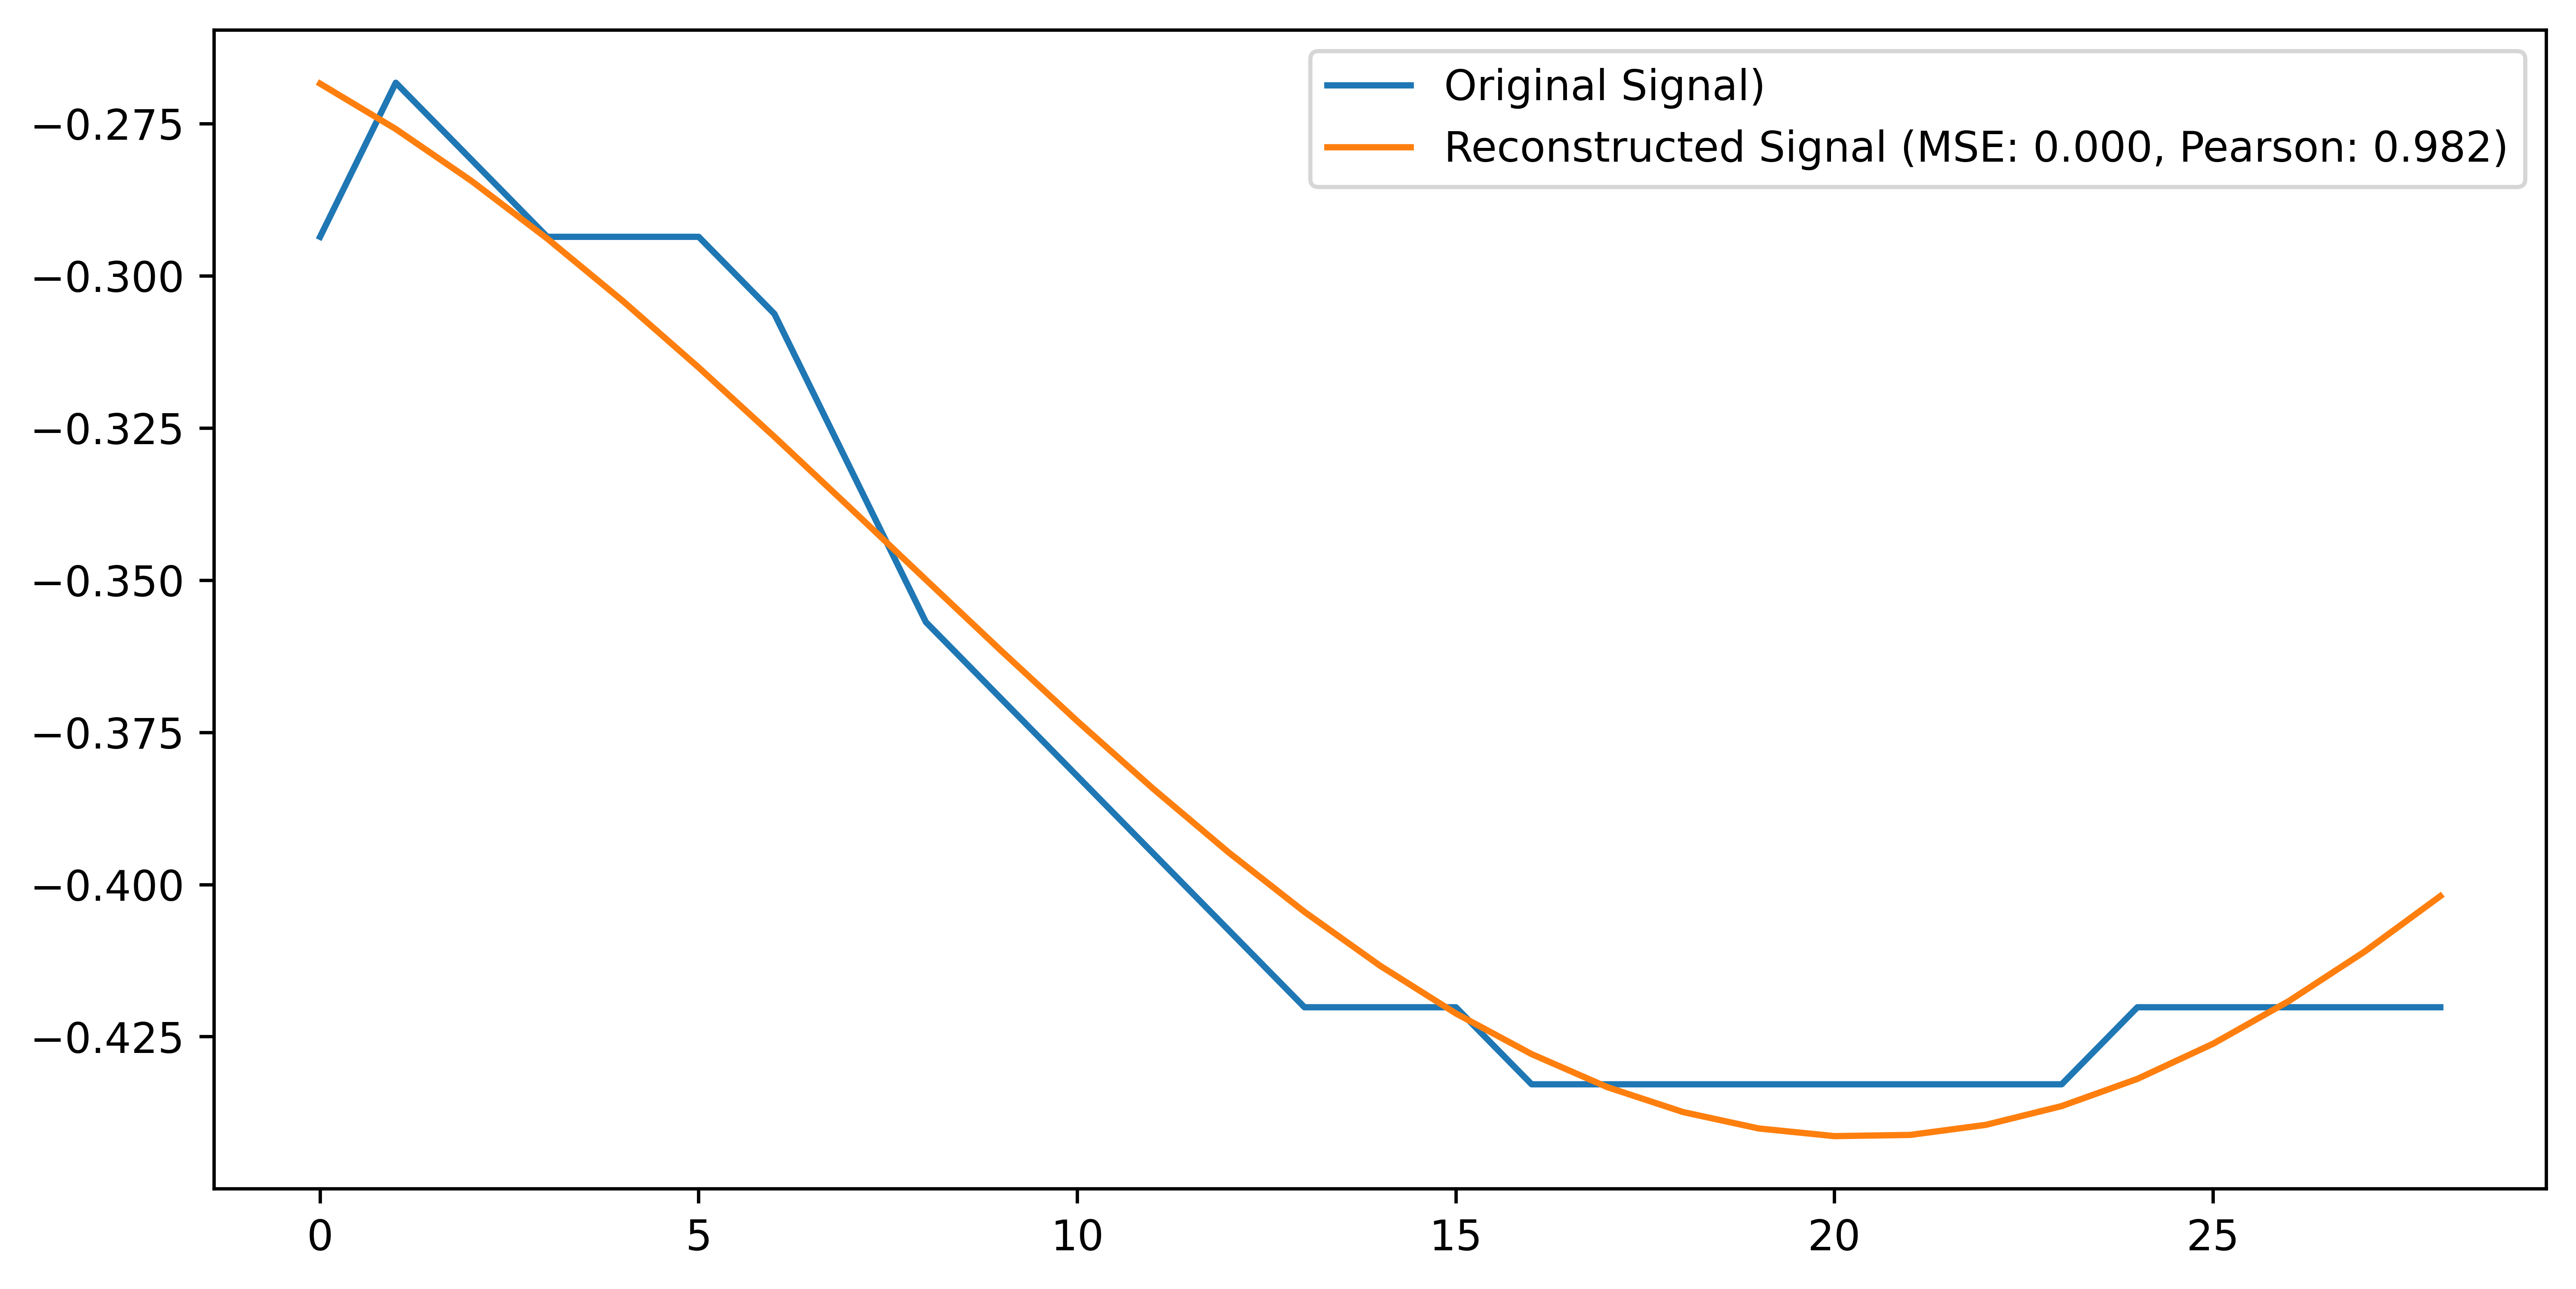

In [ ]:
approximated_signal, _ = fit_sine_to_signal(all_word_curves[idx])
plot_signals_with_mse_pearson(all_word_curves[idx], approximated_signal)